In [1]:
import pandas as pd
import numpy as np

# Load datasets
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')


# Handling Missing Values & Duplicates

In [7]:
# Helper function to quickly check for nulls and duplicates
def data_quality_report(df, name):
    print(f"\n{name} Data Overview:")
    print(f"Shape: {df.shape}")
    print("Null Values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())
    print("-" * 50)

data_quality_report(orders, "Orders")
data_quality_report(customers, "Customers")
data_quality_report(order_items, "Order Items")
data_quality_report(products, "Products")
data_quality_report(payments, "Payments")
data_quality_report(reviews, "Reviews")
data_quality_report(sellers, "Sellers")



Orders Data Overview:
Shape: (96455, 8)
Null Values:
 order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64
Duplicates: 0
--------------------------------------------------

Customers Data Overview:
Shape: (99441, 5)
Null Values:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Duplicates: 0
--------------------------------------------------

Order Items Data Overview:
Shape: (112650, 7)
Null Values:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
Duplicates: 0
--------------------------------------

In [3]:
# Remove orders that were canceled or marked unavailable
orders = orders[~orders['order_status'].isin(['canceled', 'unavailable'])]

# Drop orders where critical delivery tracking info is missing
orders = orders.dropna(subset=[
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date'
])

# Convert date columns to datetime
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
             'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])


In [4]:
# 1. Drop rows where product name, description, and category are all missing
# These rows are likely invalid products
products = products.dropna(subset=[
    'product_category_name', 
    'product_name_lenght', 
    'product_description_lenght',
    'product_photos_qty'
])

# 2. Fill missing numeric values for product dimensions with 0 (or median if preferred)
products[['product_weight_g', 'product_length_cm', 
          'product_height_cm', 'product_width_cm']] = \
    products[['product_weight_g', 'product_length_cm', 
              'product_height_cm', 'product_width_cm']].fillna(0)

# 3. (Optional) Merge with category translation for English names
products = products.merge(category_translation, how='left', on='product_category_name')
products['product_category_name'] = products['product_category_name_english']
products.drop(columns=['product_category_name_english'], inplace=True)


In [5]:
# 1. Keep all rows — review_score is always present (most important for analysis)

# 2. Optionally fill or drop empty comment columns, depending on your goals

# If you're not doing NLP or sentiment analysis:
reviews = reviews.drop(columns=['review_comment_title', 'review_comment_message'])

# If you *are* doing sentiment analysis later, you might fill NAs:
# reviews['review_comment_title'] = reviews['review_comment_title'].fillna("No Title")
# reviews['review_comment_message'] = reviews['review_comment_message'].fillna("No Message")

# 3. (Optional) Convert date columns to datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])


In [6]:
products['product_category_name'] = products['product_category_name'].fillna('unknown_category')


# Merge Key Tables

In [8]:
# 1. orders + customers
orders_customers = orders.merge(customers, on='customer_id', how='left')

# 2. + order_items
df = orders_customers.merge(order_items, on='order_id', how='left')

# 3. + products
df = df.merge(products, on='product_id', how='left')

# 4. + payments
df = df.merge(payments, on='order_id', how='left')

# 5. + reviews
df = df.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')


In [9]:
print("Final merged dataset shape:", df.shape)
df.head()

Final merged dataset shape: (115699, 31)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,4.0,500.0,19.0,8.0,13.0,1.0,credit_card,1.0,18.12,4.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,4.0,500.0,19.0,8.0,13.0,3.0,voucher,1.0,2.00,4.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,4.0,500.0,19.0,8.0,13.0,2.0,voucher,1.0,18.59,4.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,1.0,400.0,19.0,13.0,19.0,1.0,boleto,1.0,141.46,4.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,420.0,24.0,19.0,21.0,1.0,credit_card,3.0,179.12,5.0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:,.2f}'.format)


df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_14016\3671321965.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_type_counts.index, y=payment_type_counts.values, palette='Set2')


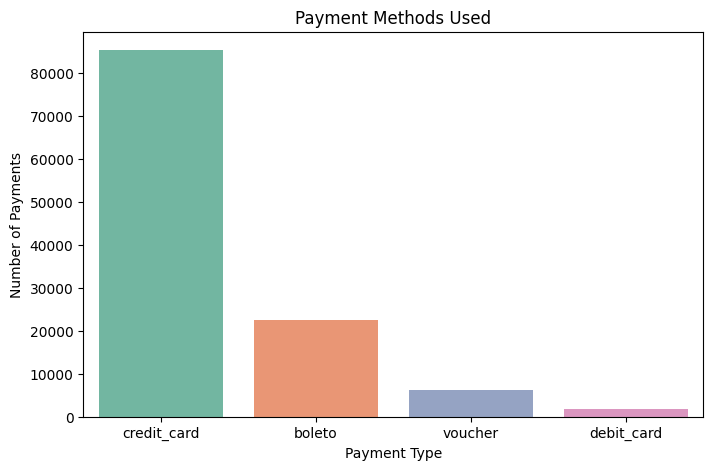

In [13]:
payment_type_counts = df['payment_type'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=payment_type_counts.index, y=payment_type_counts.values, palette='Set2')
plt.title("Payment Methods Used")
plt.ylabel("Number of Payments")
plt.xlabel("Payment Type")
plt.show()


# RFM Table

In [15]:
df['total_price'] = df['price'] + df['freight_value']
latest_date = df['order_purchase_timestamp'].max()
rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,
    'order_id': 'nunique',
    'total_price': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,customer_id,Recency,Frequency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,287,1,114.74
1,000161a058600d5901f007fab4c27140,409,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42
3,0002414f95344307404f0ace7a26f1d5,378,1,179.35
4,000379cdec625522490c315e70c7a9fb,149,1,107.01


# Top Product by Revenue

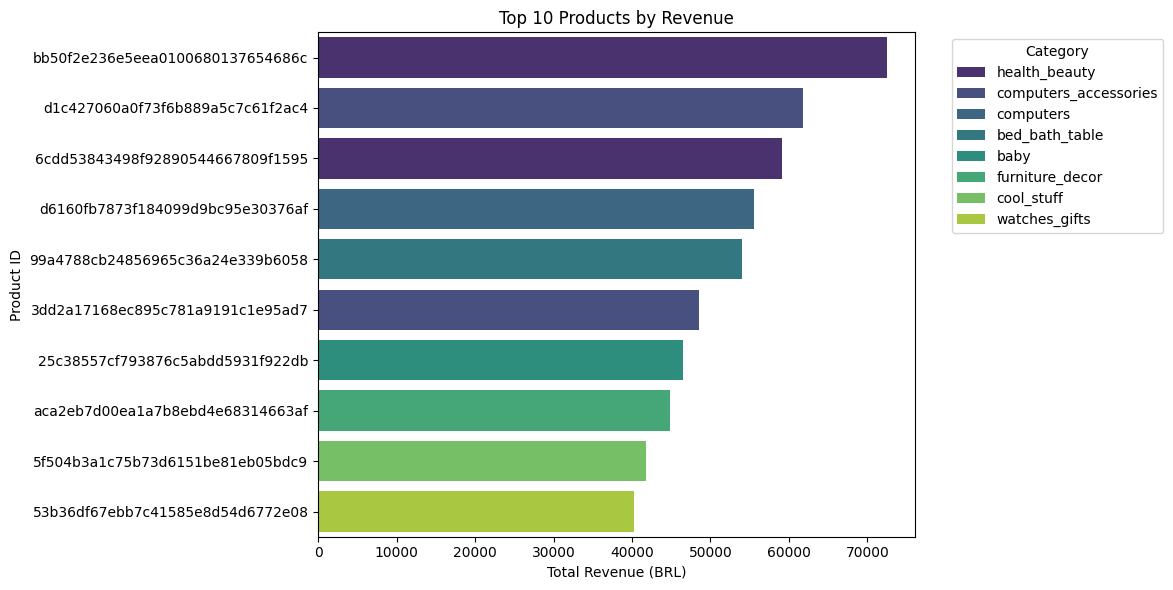

In [19]:
# Aggregate revenue by product ID
top_products_rev = df.groupby(['product_id', 'product_category_name'])['total_price'].sum().reset_index()

# Sort and take top 10
top_products_rev = top_products_rev.sort_values('total_price', ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_products_rev,
    x='total_price',
    y='product_id',
    hue='product_category_name',
    dodge=False,
    palette='viridis'
)

plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Product ID')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Number of Customers/Segments

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_14016\140869120.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='RFM_Score', palette='magma')


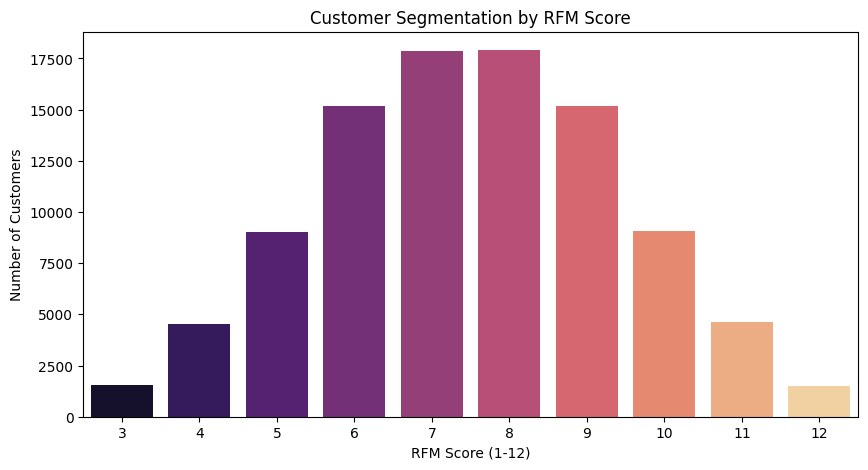

In [20]:
# Plot distribution of customers by RFM Score
plt.figure(figsize=(10,5))
sns.countplot(data=rfm, x='RFM_Score', palette='magma')

plt.title('Customer Segmentation by RFM Score')
plt.xlabel('RFM Score (1-12)')
plt.ylabel('Number of Customers')
plt.show()


# Classification of Customers

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_14016\128642899.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Segment', y='Customer Count', palette='coolwarm')


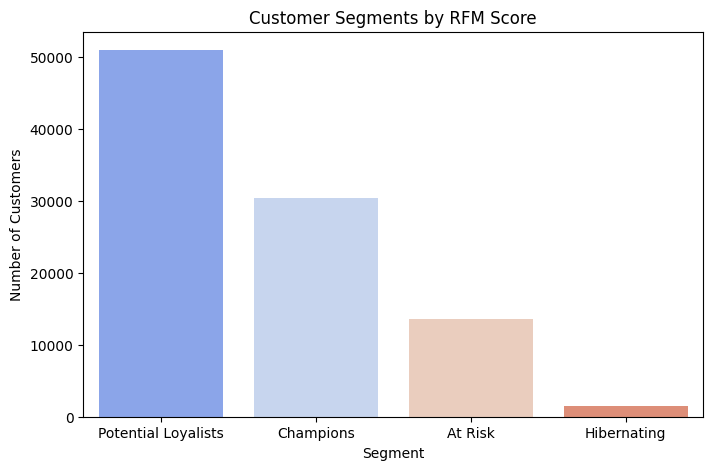

In [21]:
def assign_rfm_segment(score):
    if score >= 9:
        return 'Champions'
    elif score >= 6:
        return 'Potential Loyalists'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_rfm_segment)
# Count customers per segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer Count']

# Bar Chart
plt.figure(figsize=(8,5))
sns.barplot(data=segment_counts, x='Segment', y='Customer Count', palette='coolwarm')

plt.title('Customer Segments by RFM Score')
plt.ylabel('Number of Customers')
plt.xlabel('Segment')
plt.show()


In [22]:
df.to_csv("ecommerce_cleaned_data.csv", index=False)
rfm.to_csv("ecommerce_rfm_segments.csv", index=False)
